In [52]:
import matplotlib
matplotlib.use('TkAgg')

import requests
import urllib.request
import keras
import sklearn
import sklearn.cross_validation
import os

import pandas as pd
import seaborn as sns
import numpy as np

from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

/Users/peekabuy/projects/detect_clothes/env/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# import data
r = requests.get('https://test.flaunt.peekabuy.com/api/board/get_jc_product_images_batch/?page=3')

In [7]:
image_urls = r.json()['images']

In [15]:
data_dir = Path('../data/raw')

for url in image_urls:
    splits = url.split('/')
    filename = splits[-1]
    filepath = data_dir / filename
    urllib.request.urlretrieve(url, str(filepath))
    

../data/4fbedb7bf74ebea3381a5f94ef413eac.jpg
../data/661f7f5b758dad38ac6fdf3922c648e4.jpg
../data/97db99ef15d57e2779b6798462023659.jpg
../data/186d262630df3cbd68012ab89ba71e35.jpg
../data/92c8032a9a040ad2c68dff2918f458e6.jpg
../data/a0699e1cac5faf222ce1e8009ffae59a.jpg
../data/5e52345a3a1fe6709eb5de229b13479c.jpg
../data/a0e0ee65222834586338f17ce10e87eb.jpg
../data/a6d379e60044ee743d47e6eabe35386d.jpg
../data/80e77b7aab508f91862a11d0edd89bbc.jpg
../data/748c6281ba693ed4f3ecc486d017dd50.jpg
../data/93ba72bc36d1c2e0efd15fd21e910d32.jpg
../data/530bcb6c7858f32df07301728ae49da1.jpg
../data/f3ffb4577141d62aeb3709e6e6424c45.jpg
../data/3d7276af693af671a3d5a2f3cc06bc0e.jpg
../data/6165f54a8c68de1dad78db2a79e96c63.jpg
../data/0c6fe551acc18ac002b3e8084048743c.jpg
../data/7c2e0159e68207a35a8ff69238cf63ae.jpg
../data/5664037d3669fbcb93aee4d03942e3dd.jpg
../data/39bf523d1eb84d6ece22e481cc32edc3.jpg
../data/f121e9ac236e0e12b515b8e0d4b3de62.jpg
../data/5b6191cd14ac7a09f5b924a72958d91c.jpg
../data/a5

- Do dresses with shirts count as one thing or two things
    - try treating as one piece
- Should clothes with people in them be rejected
    - 
- Should clothes with weird backgrounds (i.e. white on white) be rejected also
    - classify them out
    
    
Do fine-grained annotation but try bucketing / not bucketing the labels

There's a list of labels that should be fed through the existing cropping pipeline and a list that need to be further examined

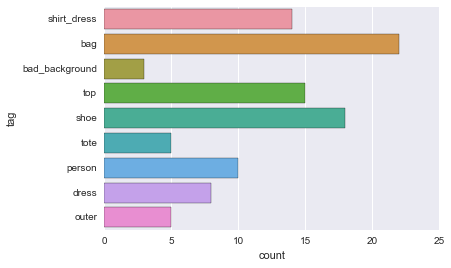

In [56]:
gt_labels = pd.read_csv('../data/raw.csv', header=None, names=['image_name', 'tag'])

sns.countplot(data=gt_labels, y='tag')

num_classes = len(gt_labels.tag.unique())

In [50]:
# fine-grained first pass

# create directory of symlinks
data_path = Path('../data')
train_finegrain_dir = data_path / 'train_finegrain'
test_finegrain_dir = data_path / 'test_finegrain'
if not train_finegrain_dir.exists():
    train_finegrain_dir.mkdir()
    
if not test_finegrain_dir.exists():
    test_finegrain_dir.mkdir()

# generate stratified split
X = gt_labels.image_name
y = gt_labels.tag

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.1, stratify=y)

# symlink train data
for im_name, label in zip(X_train, y_train):
    source_path = (data_path / 'raw' /im_name).resolve()
    dest_path = train_finegrain_dir / label / im_name
    
    class_dir = dest_path.parent
    
    if not class_dir.exists():
        class_dir.mkdir()
    
    if dest_path.exists():
        continue
    
    os.symlink(str(source_path), str(dest_path))
    
# symlink test data
for im_name, label in zip(X_test, y_test):
    source_path = (data_path / 'raw' /im_name).resolve()
    dest_path = test_finegrain_dir / label / im_name
    
    class_dir = dest_path.parent
    
    if not class_dir.exists():
        class_dir.mkdir()
    
    if dest_path.exists():
        continue
    
    os.symlink(str(source_path), str(dest_path))


In [54]:
# train / test generators
train_data_dir = str(train_finegrain_dir)
validation_data_dir = str(test_finegrain_dir)

img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')




Found 100 images belonging to 9 classes.
Found 10 images belonging to 8 classes.


In [57]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 224, 224)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [58]:
model.fit_generator(
        train_generator,
        samples_per_epoch=2000,
        nb_epoch=50,
        validation_data=validation_generator,
        nb_val_samples=800)
model.save_weights('finegrained.h5')

Epoch 1/50


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/peekabuy/projects/detect_clothes/env/lib/python3.5/site-packages/keras/engine/training.py", line 416, in data_generator_task
    generator_output = next(generator)
  File "/Users/peekabuy/projects/detect_clothes/env/lib/python3.5/site-packages/keras/preprocessing/image.py", line 442, in __next__
    return self.next(*args, **kwargs)
  File "/Users/peekabuy/projects/detect_clothes/env/lib/python3.5/site-packages/keras/preprocessing/image.py", line 580, in next
    img = load_img(os.path.join(self.directory, fname), grayscale=grayscale, target_size=self.target_size)
  File "/Users/peekab

Exception: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None